# Mocap Pose Estimation For Baseball BioMechanics

This quick exploration into single-video Pose Estimation serves as a proof-of-concept that anyone or organization can use computational biomechanics to learn and improve in the sport of baseball. Many high-end implementaions of motion capture technology and biomechanical analysis require multiple cameras, on-person markers, and complex/computationally instensive setups. This notebook contains opensource methods that any person or organization can employ with only a smartphone camera and a computer with python.

In [1]:
import cv2  # pip install opencv-python
import mediapipe as mp # pip install mediapipe
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils

## Mocap Over Video

In [3]:
pTime = 0

mocap = []

file_name = 'pitch.mp4'

cap = cv2.VideoCapture(file_name)
success, img = cap.read()
while success == True:
    
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)
    
    if results.pose_landmarks:
        mpDraw.draw_landmarks(img,results.pose_landmarks,mpPose.POSE_CONNECTIONS)
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h,w,c = img.shape
            
            cx,cy = int(lm.x*w), int(lm.y*h)
            cv2.circle(img,(cx,cy),5,(255,0,255),cv2.FILLED)

    
    cTime = time.time()
    fps = 1/(cTime-pTime)
    pTime = cTime
    cv2.putText(img,str(int(fps)),(70,50),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
    cv2.imshow("Image",img)
    cv2.waitKey(1)
    mocap.append(results.pose_landmarks)
    success, img = cap.read()
cv2.destroyAllWindows()

## Mocap over Blank Screen

In [59]:
pTime = 0

mocap = []

cap = cv2.VideoCapture(file_name)
success, img = cap.read()

h,w,c = img.shape
blank_img = np.zeros((h,w,c), np.uint8)

while success == True:
    
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)
    
    if results.pose_landmarks:
        mpDraw.draw_landmarks(blank_img,results.pose_landmarks,mpPose.POSE_CONNECTIONS)
        for id, lm in enumerate(results.pose_landmarks.landmark):
            
            cx,cy = int(lm.x*w), int(lm.y*h)
            cv2.circle(blank_img,(cx,cy),5,(255,0,255),cv2.FILLED)
            

    
    cTime = time.time()
    fps = 1/(cTime-pTime)
    pTime = cTime
    cv2.putText(img,str(int(fps)),(70,50),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
    cv2.imshow("Image",blank_img)
    cv2.waitKey(1)
    blank_img = np.zeros((h,w,c), np.uint8)
    mocap.append(results.pose_landmarks)
    success, img = cap.read()
cv2.destroyAllWindows()

### Now Let's Look At The Data

Text(0.5, 1.0, 'Side View of Pitching Motion')

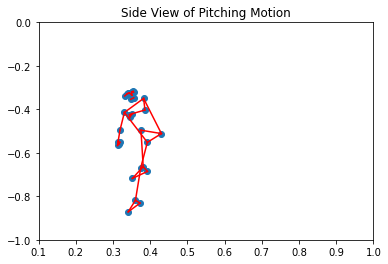

In [9]:
x = []
y = []
z = []
frame = 500
for i in range(33):
    x.append(mocap[frame].landmark[i].x)
    y.append(mocap[frame].landmark[i].y * -1) # Flipping y to negative so the figure appears "right-side-up"
plt.scatter(x,y)

for i in range(len(list(mpPose.POSE_CONNECTIONS))):
    point = list(mpPose.POSE_CONNECTIONS)[i]
    plt.plot([x[point[0]],x[point[1]]],[y[point[0]],y[point[1]]], c = 'r')
   
plt.ylim(-1,0)
plt.xlim(0.1,1)
plt.title("Side View of Pitching Motion")

<IPython.core.display.Javascript object>


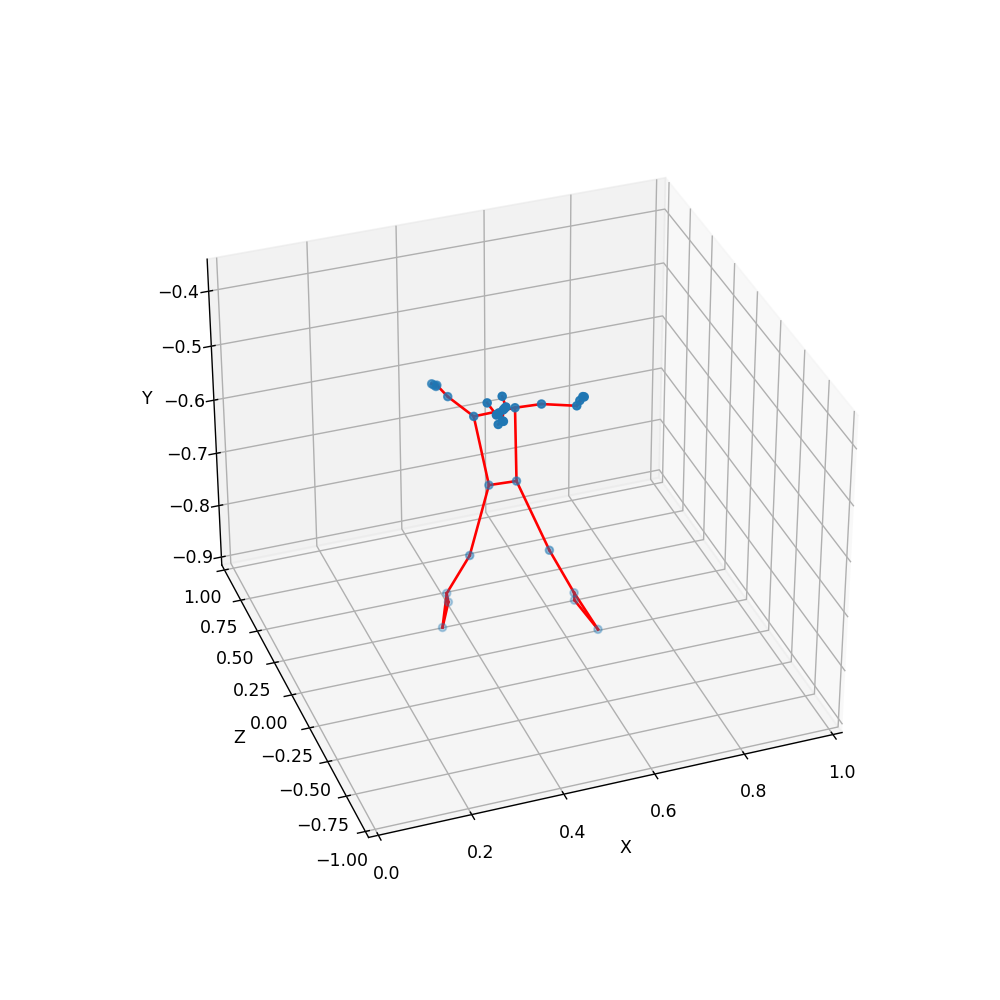

(-1.0, 1.0)

In [48]:
#########################################################CAUTION#########################################################
# Running this cell will break other matplotlib cells and will require kernel restart to continue
%matplotlib notebook

fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(projection='3d')

x = []
y = []
z = []
frame = 577
for i in range(33):
    x.append(mocap[frame].landmark[i].x)
    y.append(mocap[frame].landmark[i].y * -1) # Flipping y to negative so the figure appears "right-side-up"
    z.append(mocap[frame].landmark[i].z)
ax.scatter(x,z,y)


for i in range(len(list(mpPose.POSE_CONNECTIONS))):
    
    point = list(mpPose.POSE_CONNECTIONS)[i]
    ax.plot([x[point[0]],x[point[1]]],
            [z[point[0]],z[point[1]]],
            [y[point[0]],y[point[1]]],c = 'r')

ax.set_xlabel('X ')
ax.set_ylabel('Z ')
ax.set_zlabel('Y ')
ax.set_xlim(0,1)
ax.set_ylim(-1,1)



 # Lets Get Some Real Data
 
 #### Lets start off by finding the Scap angle for a given frame
 

In [26]:
frame = 577
r_s = np.array([mocap[frame].landmark[12].x,mocap[frame].landmark[12].z]) # Right Shoulder 
l_s = np.array([mocap[frame].landmark[13].x,mocap[frame].landmark[13].z]) # Left Shoulder
r_e = np.array([mocap[frame].landmark[14].x,mocap[frame].landmark[14].z]) # Right Elbow

In this instance, we have three points with which we can make our observations: r_s, l_s, r_e. These points represent the right shoulder, left shoulder, and right elbow respectively. The Scap angle will be the angle between the right elbow and left shoulder if we represent them as vector originating from the right shoulder. So, lets create our vectors with the right shoulder as our origin and find our scap angle. <br>

As a limitation of our methods, the y component of each vector will be disregarded as its is not the relevant dimension and can skew the results. Further exploration can be pursued for the sake of accuracy such a projection methods using the y dimension in the creation of a plane between the relevant points with which you use as a vector space.

In [24]:
# https://www.askpython.com/python/array/angles-between-n-dimensional-vectors

import math
def angles(u, v): 
  
  return np.arccos(u.dot(v)/(np.linalg.norm(u)*np.linalg.norm(v)))

#defining some test vectors
u = np.array([3, -4])
v = np.array([2, 7])


math.degrees(angles(u,v))

127.18470645323312

In [27]:
u = l_s - r_s # Creating first vector of origin to left shoulder
v = r_e - r_s # Creating second vector of origin to right elbow

In [28]:
math.degrees(angles(v,u)) # Getting the Angle from a single frame 

143.14874199273046

After some quick trigonometry, we can see the scap angle for any given frame. Now, lets do this for all frames to get a better picture of the pitching motion.

In [53]:
scap_angles = []
for i in range(len(mocap)-1):
     r_s = np.array([mocap[i+1].landmark[11].x,mocap[i+1].landmark[11].z]) # Right Shoulder 
     l_s = np.array([mocap[i+1].landmark[12].x,mocap[i+1].landmark[12].z]) # Left Shoulder
     r_e = np.array([mocap[i+1].landmark[14].x,mocap[i+1].landmark[14].z]) # Right Elbow
     
     u = l_s - r_s # Creating first vector of origin to left shoulder
     v = r_e - r_s # Creating second vector of origin to right elbow
    
     scap_angles.append(math.degrees(angles(u,v))) # Getting the Angle from a single frame 

<IPython.core.display.Javascript object>


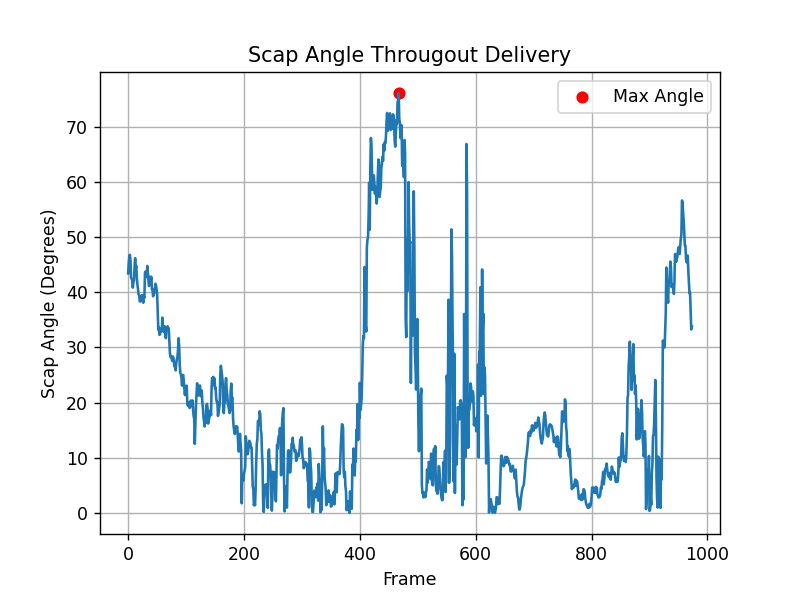

In [55]:
plt.plot(np.arange(0,len(scap_angles)),scap_angles)
plt.scatter(scap_angles.index(max(scap_angles[400:])),max(scap_angles[400:]), c = 'r', label = "Max Angle")
plt.xlabel("Frame")
plt.ylabel("Scap Angle (Degrees)")
plt.title("Scap Angle Througout Delivery")
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


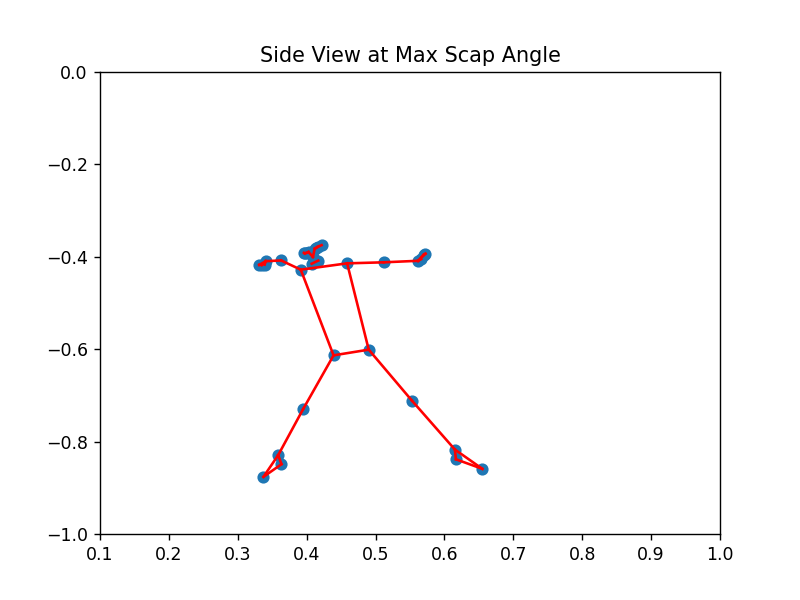

Text(0.5, 1.0, 'Side View at Max Scap Angle')

In [57]:
x = []
y = []
z = []
frame = scap_angles.index(max(scap_angles[500:]))
for i in range(33):
    x.append(mocap[frame].landmark[i].x)
    y.append(mocap[frame].landmark[i].y * -1) # Flipping y to negative so the figure appears "right-side-up"
plt.scatter(x,y)

for i in range(len(list(mpPose.POSE_CONNECTIONS))):
    point = list(mpPose.POSE_CONNECTIONS)[i]
    plt.plot([x[point[0]],x[point[1]]],[y[point[0]],y[point[1]]], c = 'r')
   
plt.ylim(-1,0)
plt.xlim(0.1,1)
plt.title("Side View at Max Scap Angle")

In [58]:
max(scap_angles[500:])

66.85080910035295